# Electrical Power Generation Problem - UC

## Objective and Prerequisites

This model is an example of an electrical power generation problem (also known as a unit commitment problem). It selects an optimal set of power stations to turn on in order to satisfy anticipated power demand over a 24-hour time horizon.  This example is modified by W. de Oliveira (www.oliveira.mat.br). The goal is to extend the basic model to a stochastic setting, using a probability constraints.

The basic model is example 16 from the fifth edition of Model Building in Mathematical Programming, by H. Paul Williams on pages 271-272 and 326-327.




---
## Problem Description

In this problem, thermal power generation units are grouped into three distinct types, with different characteristics for each type (power output, cost per megawatt hour, startup cost, etc.).  A unit can be on or off, with a startup cost associated with transitioning from off to on, and power output that can fall anywhere between a specified minimum and maximum value when the unit is on.  There are also two hydroelectric plants available, also with different cost and power generation characteristics.  A 24-hour time horizon is divided into 5 discrete time periods. Except for the first period, which is assumed detetministic,  total power demand is random. Given a possible realization of the random vector of power demand, the basic model decides which units to turn on, and when, in order to satisfy the *given demand* for each time period.  The model also captures a reserve requirement, where the selected power plants must be capable of increasing their output, while still respecting their maximum output, in order to cope with the situation where actual demand exceeds predicted demand.

A set of generators is available to satisfy power demand for the following day.  The average demand is as follows:

| Time Period | Avg Demand (megawatts) |
| --- | --- |
| 12 pm to 6 am | 15000 |
| 6 am to 9 am | 30000 |
| 9 am to 3 pm | 25000 |
| 3 pm to 6 pm | 40000 |
| 6 pm to 12 pm | 27000 |

Thermal generators are grouped into three types, with the following minimum and maximum output for each type (when they are on):

| Type | Number available | Minimum output (MW) | Maximum output (MW) |
| --- | --- | --- | --- |
| 0 | 12 |  850 | 2000 |
| 1 | 10 | 1250 | 1750 |
| 2 | 5 | 1500 | 4000 |

There are costs associated with using a thermal generator: a cost per hour when the generator is on (and generating its minimum output), a cost per megawatt hour above its minimum, and a startup cost for turning a generator on:

| Type | Cost per hour (when on) | Cost per MWh above minimum | Startup cost |
| --- | --- | --- | --- |
| 0 | $\$1000$ | $\$2.00$ | $\$2000$ |
| 1 | $\$2600$ | $\$1.30$ | $\$1000$ |
| 2 | $\$3000$ | $\$3.00$ | $\$500$ |

Two hydroelectric generators are also available, each with a fixed power output (when on):

| Hydro plant | Output (MW) |
| --- | --- |
| A | 900 |
| B | 1400 |

The costs associated with using a hydro plant are slightly different.  There's an hourly cost, but it is much smaller than the hourly cost of a thermal generator.  The real cost for a hydroelectric plant comes from depletion of the water in the reservoir, which happens at different rates for the two units.  The reservoir must be replenished before the end of the time horizon by pumping water into it, which consumes electricity.  A hydroelectric plant also has a startup cost.

| Hydro plant | Cost per hour (when on) | Startup cost | Reservoir depth reduction (m/hr) |
| --- | --- | --- | --- |
| A | $\$90$ | $\$1500$ | 0.31 |
| B | $\$150$ | $\$1200$ | 0.47 |

Pumping water into the reservoir consumes electricity at a rate of 3000 MWh of electricity per meter of height.  The height of the reservoir at the end of the time horizon must be equal to the height at the beginning.


---
## Model Formulation: Desterministic Setting
Given a scenario demand, i.e., a possible realization of the future random demand, the question we wish to answer is: 
which generators should be committed to meet anticipated demand in order to minimize total cost?

### Sets and Indices

$t \in \text{Types}=\{0,1,2\}$: Types of thermal generators.

$h \in \text{HydroUnits}=\{0,1\}$: Two hydro generators.

$p \in \text{Periods}=\{0,1,2,3,4\}$: Time periods.

### Parameters

$\text{period_hours}_{p} \in \mathbb{N}^+$: Number of hours in each time period.

$\text{demand}_p \in \mathbb{R}^+$: Total power demand for time period $p$.

$\text{generators}_t \in \mathbb{N}^+$: Number of thermal generators of type $t$.

$\text{start0} \in \mathbb{N}^+$: Number of thermal generators that are on at the beginning of the time horizon (and available in time period 0 without paying a startup cost).

$\text{min_output}_t \in \mathbb{R}^+$: Minimum output for thermal generator type $t$ (when on).

$\text{max_output}_t \in \mathbb{R}^+$: Maximum output for thermal generator type $t$.

$\text{base_cost}_t \in \mathbb{R}^+$: Minimum operating cost (per hour) for a thermal generator of type $t$.

$\text{per_mw_cost}_t \in \mathbb{R}^+$: Cost to generate one additional MW (per hour) for a thermal generator of type $t$.

$\text{startup_cost}_t \in \mathbb{R}^+$: Startup cost for thermal generator of type $t$.

$\text{hydro_load}_h \in \mathbb{R}^+$: Output for hydro generator $h$.

$\text{hydro_cost}_h \in \mathbb{R}^+$: Cost for operating hydro generator $h$.

$\text{hydro_startup_cost}_h \in \mathbb{R}^+$: Startup cost for hydro generator $h$.

$\text{hydro_height_reduction}_h \in \mathbb{R}^+$: Hourly reduction in reservoir height from operating hydro generator $h$.

### Decision Variables

$\text{ngen}_{t,p} \in \mathbb{N}^+$: Number of thermal generators of type $t$ that are on in time period $p$.

$\text{output}_{t,p} \in \mathbb{R}^+$: Total power output from thermal generators of type $t$ in time period $p$.

$\text{nstart}_{t,p} \in \mathbb{N}^+$: Number of thermal generators of type $t$ to start in time period $p$.

$\text{hydro}_{h,p} \in [0,1]$: Indicates whether hydro generators $h$ is on in time period $p$.

$\text{hydro_start}_{h,p} \in [0,1]$: Indicates whether hydro generator $h$ starts in time period $p$.

$\text{height}_{p} \in \mathbb{R}^+$: Height of reservoir in time period $p$.

$\text{pumping}_{p} \in \mathbb{R}^+$: Power used to replenish reservoir in time period $p$.


### Objective Function

- **Cost**: Minimize the cost (in USD) to satisfy the predicted electricity demand.

\begin{equation}
\text{Minimize} \quad Z_{on} + Z_{extra} + Z_{startup} + Z_{hydro} + Z_{hydro\_startup}
\end{equation}

\begin{equation}
Z_{on} = \sum_{(t,p) \in \text{Types} \times \text{Periods}}{\text{base_cost}_t*\text{ngen}_{t,p}}
\end{equation}
\begin{equation}
Z_{extra} = \sum_{(t,p) \in \text{Types} \times \text{Periods}}{\text{per_mw_cost}_t*(\text{output}_{t,p} - \text{min_load}_t})
\end{equation}
\begin{equation}
Z_{startup} = \sum_{(t,p) \in \text{Types} \times \text{Periods}}{\text{startup_cost}_t*\text{nstart}_{t,p}}
\end{equation}
\begin{equation}
Z_{hydro} = \sum_{(h,p) \in \text{HydroUnits} \times \text{Periods}}{\text{hydro_cost}_h*\text{hydro}_{h,p}}
\end{equation}
\begin{equation}
Z_{hydro\_startup} = \sum_{(h,p) \in \text{HydroUnits} \times \text{Periods}}{\text{hydro_startup_cost}_h*\text{hydro_start}_{h,p}}
\end{equation}


### Constraints

- **Available generators** (SetCons \#1): Number of generators used must be less than or equal to the number available.

\begin{equation}
\text{ngen}_{t,p} \leq \text{generators}_t  \quad \forall (t,p) \in \text{Types} \times \text{Periods}
\end{equation}

- **Min/max generation** (SetCons \#2): Power generation must respect thermal generator min/max values.

\begin{equation}
\text{output}_{t,p} \geq \text{min_output}_t*\text{ngen}_{t,p} \quad \forall (t,p) \in \text{Types} \times \text{Periods}
\end{equation}

\begin{equation}
\text{output}_{t,p} \leq \text{max_output}_t*\text{ngen}_{t,p} \quad \forall (t,p) \in \text{Types} \times \text{Periods}
\end{equation}


- **Thermal startup** (SetCons \#3): Establish relationship between number of active thermal generators and number of startups (use $start0$ for period before the time horizon starts)

\begin{equation}
\text{ngen}_{t,p} \leq \text{ngen}_{t,p-1} + \text{nstart}_{t,p} \quad \forall (t,p) \in \text{Types} \times \text{Periods}
\end{equation}

- **Hydro startup** (SetCons \#4): Establish relationship between hydro generator state and number of hydro startups (assume hydro plants are off at the beginning of the horizon)

\begin{equation}
\text{hydro}_{h,p} \leq \text{hydro}_{h,p-1} + \text{hydro_start}_{h,p} \quad \forall (h,p) \in \text{HydroUnits} \times \text{Periods}
\end{equation}

- **Reservoir height** (SetCons \#5): Track reservoir height.   Note that the height at the end of the final time period must equal the height at the beginning of the first.

- Reservoir level constraints: Height increases due to pumping activity and decreases due to hydroelectric generation.

\begin{equation}
\text{height}_{p} = \text{height}_{p-1}  + \text{period_hours}_{p}*\text{pumping}_{p}/3000 -
\sum_{h \in \text{HydroUnits}}{\text{period_hours}_{p}*\text{hydro_height_reduction}_{h}*\text{hydro}_{h,p}} \quad \forall p \in \text{Periods}
\end{equation}

- Cyclic constraint: Height at the first period must be equal to height at the last period.

\begin{equation}
\text{height}_{pfirst} = \text{height}_{plast}  + \text{period_hours}_{pfirst}*\text{pumping}_{pfirst}/3000 -
\sum_{h \in \text{HydroUnits}}{\text{period_hours}_{pfirst}*\text{hydro_height_reduction}_{h}*\text{hydro}_{h,pfirst}}
\end{equation}


- **Demand** (SetCons \#6): Total power generated across all generator types must meet the given demand scenario plus pumping for each time period $p$.

\begin{equation}
\sum_{t \in \text{Types}}{\text{output}_{t,p}} +
\sum_{h \in \text{HydroUnits}}{\text{hydro_load}_h*\text{hydro}_{h,p}} \geq
\text{demand}_p + \text{pumping}_p \quad \forall p \in \text{Periods}
\end{equation}

---
## Python Implementation

We import the Gurobi Python Module and other Python libraries.

In [103]:
#%pip install -i https://pypi.gurobi.com gurobipy

In [1]:
import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt

#tested with python 3.9 Gurobi 9.5.1

## Input Data
We define all the input data of the model.

In [2]:
# Parameters

ntypes = 3
nperiods = 5
maxstart0 = 5
hydrounits = 2
Nscen      = 300

generators = [12, 10, 5]
period_hours = [6, 3, 6, 3, 6]

# Average of the random demand
demand = [15000, 30000, 25000, 40000, 27000]

min_load = [850, 1250, 1500]
max_load = [2000, 1750, 4000]
base_cost = [1000, 2600, 3000]
per_mw_cost = [2, 1.3, 3]
startup_cost = [2000, 1000, 500]

hydro_load = [900, 1400]
hydro_cost = [90, 150]
hydro_height_reduction = [0.31, 0.47]
hydro_startup_cost = [1500, 1200]

## Deterministic Model

We create a model and the variables. For each time period, we have: 
* an integer decision variable to capture the number of active 
generators of each type (ngen), 
* an integer variable to capture the number of generators of each type we must start (nstart), 
*a continuous decision variable to capture the total power output for each generator type (output), 
* a binary decision variable that indicates whether a hydro unit is active (hydro), 
* a binary decision variable that indicates whether a hydro unit must be started (hydrstart), 
* a continuous decision variable that captures the amount of enery used to replenish the reservoir (pumping), and 
* **a** continuous decision variable that captures the height of the reservoir (height).

In [3]:
model = gp.Model('DeterministicUC')

ngen = model.addVars(ntypes, nperiods, vtype=GRB.INTEGER, name="ngen")
nstart = model.addVars(ntypes, nperiods, vtype=GRB.INTEGER, name="nstart")
output = model.addVars(ntypes, nperiods, vtype=GRB.CONTINUOUS, name="genoutput")

hydro = model.addVars(hydrounits, nperiods, vtype=GRB.BINARY, name="hydro")
hydrostart = model.addVars(hydrounits, nperiods, vtype=GRB.BINARY, name="hydrostart")
pumping = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="pumping")
height = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="height")

Restricted license - for non-production use only - expires 2023-10-25


---
### Objective
Minimize total cost. Cost consists of five components: the cost for running active thermal generation units, the cost to generate power beyond the minimum for each unit, the cost to start up thermal generation units, the cost to operate hydro units, and the cost to start up hydro units.

In [4]:
# Objective: minimize total cost

active = gp.quicksum(base_cost[type]*period_hours[period]*ngen[type,period]
                    for type in range(ntypes) for period in range(nperiods))

per_mw = gp.quicksum(per_mw_cost[type]*period_hours[period]*(output[type,period] - min_load[type]*ngen[type,period])
                       for type in range(ntypes) for period in range(nperiods))

startup_obj = gp.quicksum(startup_cost[type]*nstart[type,period]
                         for type in range(ntypes) for period in range(nperiods))

hydro_active = gp.quicksum(hydro_cost[unit]*period_hours[period]*hydro[unit,period]
                           for unit in range(hydrounits) for period in range(nperiods))

hydro_startup = gp.quicksum(hydro_startup_cost[unit]*hydrostart[unit,period]
                            for unit in range(hydrounits) for period in range(nperiods))

model.setObjective(active + per_mw + startup_obj + hydro_active + hydro_startup)

---
### Constraints
Next we insert the constraints:

* SetCons \#1. The number of active generators can't exceed the number of generators:

In [5]:
# Generator count

numgen = model.addConstrs(ngen[type, period] <= generators[type]
                         for type in range(ntypes) for period in range(nperiods))

* SetCons \#2. Total power output for a thermal generator type depends on the number of generators of that type that are active.

In [6]:
# Respect minimum and maximum output per generator type

min_output = model.addConstrs((output[type, period] >= min_load[type] * ngen[type, period])
                              for type in range(ntypes) for period in range(nperiods))

max_output = model.addConstrs((output[type, period] <= max_load[type] * ngen[type, period])
                              for type in range(ntypes) for period in range(nperiods))

* SetCons \#3. Connect the decision variables that capture active thermal generators with the decision variables that count startups.

In [7]:
# Startup constraint

startup0 = model.addConstrs((ngen[type,0] <= maxstart0 + nstart[type,0])
                            for type in range(ntypes))

startup = model.addConstrs((ngen[type,period] <= ngen[type,period-1] + nstart[type,period])
                           for type in range(ntypes) for period in range(1,nperiods))

* SetCons \#4. Connect hydro decision variables with hydro startup decision variables.

In [8]:
# Hydro startup constraint

hydro_startup0 = model.addConstrs((hydro[unit,0] <= hydrostart[unit,0])
                                    for unit in range(hydrounits))

hydro_startup = model.addConstrs((hydro[unit,period] <= hydro[unit,period-1] + hydrostart[unit,period])
                           for unit in range(hydrounits) for period in range(1,nperiods))

* SetCons \#5. Maintain appropriate reservoir levels

In [9]:
# Reservoir levels

reservoir = model.addConstrs(height[period] == height[period-1] + period_hours[period]*pumping[period]/3000 -
                             gp.quicksum(hydro_height_reduction[unit]*period_hours[period]*hydro[unit,period] for unit in range(hydrounits))
                             for period in range(1,nperiods))

# cyclic - height at end must equal height at beginning
reservoir0 = model.addConstr(height[0] == height[nperiods-1] + period_hours[0]*pumping[0]/3000 -
                             gp.quicksum(hydro_height_reduction[unit]*period_hours[0]*hydro[unit,0]
                             for unit in range(hydrounits)))

* SetCons \#6. Total generator output (thermal plus hydro) for each time period must meet the given demand scenario plus pumping.

In [10]:
# Meet demand

meet_demand = model.addConstrs(gp.quicksum(output[type, period] for type in range(ntypes)) +
                               gp.quicksum(hydro_load[unit]*hydro[unit,period] for unit in range(hydrounits))
                               >= demand[period] + pumping[period]
                               for period in range(nperiods))

---
### Solving Deterministic Model 
Next, we start the optimization and Gurobi finds the optimal solution.

In [11]:
model.optimize()
model.printAttr('objVal')

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 80 rows, 75 columns and 200 nonzeros
Model fingerprint: 0x1afdcda8
Variable types: 25 continuous, 50 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e-03, 4e+03]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 4e+04]
Presolve removed 18 rows and 3 columns
Presolve time: 0.00s
Presolved: 62 rows, 72 columns, 179 nonzeros
Variable types: 25 continuous, 47 integer (18 binary)
Found heuristic solution: objective 1062020.0000

Root relaxation: objective 9.985143e+05, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 998514.286    0    7 1062020.00 998514.286  5.98%     -    0s
H    0     0                    1008435.0

---
### Analysis

The averaged demand for electricity over the 24-hour time window can be met for a total cost of $\$1,000,130$. The detailed plan for each time period is as follows.

### Unit Commitments

The following table shows the number of thermal generators of each type that are active in each time period in the optimal solution:

In [12]:
rows = ["Thermal" + str(t) for t in range(ntypes)]
units = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for t in range(ntypes):
    for period in range(nperiods):
        units.loc["Thermal"+str(t), period] = ngen[t,period].x
units

,0,1,2,3,4
Thermal0,12.0,12.0,12.0,12.0,12.0
Thermal1,3.0,9.0,9.0,9.0,9.0
Thermal2,0.0,0.0,0.0,-0.0,0.0


The following shows the number of generators of each type that must be started in each time period to achieve this plan (recall that the model assumes that 5 are available at the beginning of the time horizon):

In [13]:
rows = ["HydroA", "HydroB"]
hydrotable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for period in range(nperiods):
    hydrotable.loc["HydroA", period] = int(hydro[0,period].x)
    hydrotable.loc["HydroB", period] = int(hydro[1,period].x)
hydrotable

,0,1,2,3,4
HydroA,0.0,0.0,0.0,0.0,0.0
HydroB,0.0,0.0,0.0,1.0,1.0


The hydro plants are lightly used in the schedule - we only use plant B for the last two time periods.

The following shows the pumping that must be done in order to support this level of hydro activity

In [14]:
pumptable = pd.DataFrame(columns=range(nperiods), index=["Pumping"], data=0.0)

for period in range(nperiods):
        pumptable.loc["Pumping", period] = pumping[period].x
pumptable

,0,1,2,3,4
Pumping,815.0,0.0,950.0,0.0,350.0


It is interesting to note that the plan simultaneously operates HydroB and pumps in time period 4.
While it might appear that costs could be reduced by operating the hydro plant at a lower load, in this model the hydro plants have fixed output.  If it makes economic sense to turn a hydro plant on, then we have to replenish the water drained, even if it means using some of the generated electricity to pump.

---
## Stochastic Model
In this section we consider a stochastic variant of the problem. We assume that the load demand is uncertain from the second period on, but follows a known probability distribution.

The goal is to find an optimal set of power stations to turn on in order to satisfy the random power demand with a probability of at least $p_{level} \in [0,1]$.
The constraints (SetCons #6) above is replace by

- **Random Demand - continuous** (SetCons \#6'): Total power generated across all generator types must meet the random demand  plus pumping for each time period with probability $p_{level}$:

\begin{equation}
\mathbb{P}\left[\sum_{t \in \text{Types}}{\text{output}_{t,p}} +
\sum_{h \in \text{HydroUnits}}{\text{hydro_load}_h*\text{hydro}_{h,p}} \geq
\textbf{ demand}_p + \text{pumping}_p \quad \forall p \in \text{Periods}\right] \geq  p_{level}
\end{equation}

The uncertainties will be represented by $Nscen$ scenarios of demand, drawn from a
 Gaussian probability distribution with average given by the vector *demand* above, and covariace matrix: 
 $$
 Cov = \left[
  \begin{array}{llllllllll}
   265000&      475000&      650000&      700000\\
      475000&     1300000&      750000&     1650000\\
      650000&      750000&     2500000&     2000000\\
      700000&    1650000&     2000000&     4700000
     \end{array}\right]
  $$

## Task 1

Reformulate the above probability constraint by using $Nscen$ scenarios $\textbf{demand}_p^{i} \in R^5$ of demand, having probability $Pr_i$, $i=1,\ldots,N$.

## Task 2
Write a code to generate $Nscen\geq 1$ correlated scenarios following the stated probability distribution. Set a seed for the random number generator: use 
np.random.seed(0).

(Hint: Generated $S \in R^{Nscen \times 4}$ from the standard normal distribution. Compute the Cholesky decomposition of $Cov = C^\top C$. Set $Scen = demand + S\cdot C$. Enlarge matrix $Scen$ by adding the first column with all values equal to $demand_1$.)

## Task 3
Using your code for Task 2, generate a sample of $Nscen=300$ correlated scenarios. Assign the probability $Pr_i=1/Nscen$ for every scenario.
* a) Plot this sample. 
* b) What is the percentage of scenarios satisfied by the determinist solution?

## Task 4
Using the above sample, solve the resulting chance-constrained problem (Task 1) with probability level $p_{level}=0.9$. Compare the following outputs with those from the deterministic model: 
* a) Costs
* b) Thermal production
* c) hydro production
* d) Pumping

What happens when reliability is increased to $p_{level}=0.95$

## Task 5 (Bonus)
This task is optional.

Generate a sample with $Nscen =1000$ scenarios. Pre-process this sample to reduce its size. Repeat Task 4 with this pre-processed sample.

---

## Task 1
Considering the stochastic model, an other decision variable needs to be introduced:

 - $\text{z}_{i} \in [0,1]$: Indicates wether a scenario is chosen or not for i \in \text{[1,Nscen]}


The constraint over the demand will change in the stockastic model, introducing the different scenario with the probability associated.

- **Demand** (ChangedCons \#6): Total power generated across all generator types must meet the random demand  plus pumping for each time period and for the scenario chosen $i$:

\begin{equation}
\sum_{t \in \text{Types}}{\text{output}_{t,p}} +
\sum_{h \in \text{HydroUnits}}{\text{hydro_load}_h*\text{hydro}_{h,p}} \geq
\text{z}_{i}*\text{demand}^i_p + \text{pumping}_p 
\quad \forall (p,i) \in \text{Periods} \times \text{[1,Nscen]}
\end{equation}

- **Probability** (SetCons \#7):  The sum of the probability scenarios chosen must be at least equals to the probability  $p_{level}$:
\begin{equation}
\sum_{i \in \text{[1,Nscen]}}{z_i * Pr_i} \geq \text{p}_{level}
\end{equation}


## Task 2

In [15]:
# Task 2
#Generation of the different demand scenario put into the matrix Scen
Nscen      = 300
Cov = [[265000, 475000, 650000, 700000],
       [475000, 1300000, 750000, 1650000],
       [650000, 750000, 2500000, 2000000],
       [700000, 1650000, 2000000, 4700000]]
#generate the random scenario
np.random.seed(0)
Scen = np.random.multivariate_normal(demand[1:], Cov, Nscen)
#add the first known demand
premier = demand[0]*np.ones((Nscen,1))
Scen = np.concatenate((premier,Scen), axis = 1)

## Task 3

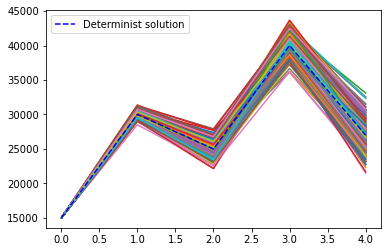

In [16]:
# Task 3
#Plot of the different scenario
plt.plot(np.transpose(Scen));

#Define the total production of the determinst solution
TotalProd = []
for period in range(nperiods):
    som = 0
    for t in range(ntypes):
        som += output[t,period].x
    for unit in range(hydrounits):
        som += hydro_load[unit] * hydro[unit,period].x
    TotalProd.append(som - pumping[period].x)

#Plot the determist demand
plt.plot([0,1,2,3,4],TotalProd,'--',color = 'blue', label = 'Determinist solution')
plt.legend()

In [17]:
#Calcul of the percentage
perc = 0
for iscen in range(Nscen):
    j=0
    for period in range(nperiods):
        if TotalProd[period]>=Scen[iscen,period]:
            j += 1
        if j == nperiods:
            perc += 1
perc = 100*perc/Nscen
    
print(f"The percentage of scenarios satisfied by the determinist solution is {perc} %")

The percentage of scenarios satisfied by the determinist solution is 25.0 %


The determist solution here is very risky since it covers only 25% of the scenarios

## Task 4

In [18]:
#Parameters
#equiprobability of the scenarios
Pr = [1/Nscen for i in range(Nscen)] 
p = 0.9

In [19]:
#Task 4
#Redefinition of the model

#Define the new binary variable
z = model.addVars(Nscen, vtype=GRB.BINARY, name="prob")

#Constraint
#Meet demand
meet_demand = model.addConstrs(gp.quicksum(output[type, period] for type in range(ntypes)) +
                               gp.quicksum(hydro_load[unit]*hydro[unit,period] for unit in range(hydrounits))
                               >= z[iscen]*Scen[iscen,period] + pumping[period]
                               for period in range(nperiods) 
                               for iscen in range(Nscen))
#Probability
probability = model.addConstr((gp.quicksum(z[iscen]*Pr[iscen] for iscen in range(Nscen))) >= p )

model.update()

In [20]:
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1581 rows, 375 columns and 11000 nonzeros
Model fingerprint: 0x7d661421
Variable types: 25 continuous, 350 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-03, 4e+04]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 4e+04]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 18 rows and 3 columns
Presolve time: 0.01s
Presolved: 1563 rows, 372 columns, 10979 nonzeros
Variable types: 25 continuous, 347 integer (318 binary)
Found heuristic solution: objective 1211602.2258
Found heuristic solution: objective 1178789.2824

Root relaxation: objective 9.985143e+05, 378 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd  

---
The optimise solution for $p = 0.9$ is $1,084,822.899110€$ with $Nscen = 300 $ compared to $\$1,000,130$ in the determinist model. This is translated by an increase of $8.47\%$ of the price to cover $65\%$ more scenario.

The optimize solution for $p = 0.95$ is $1,096,410.292456€$ with $Nscen = 300 $. This is translated by an increase of $9.63\%$ for covering $70\%$ more scenario than the determistic solution.

---
### Analysis

The averaged demand for electricity over the 24-hour time window can be met for a total cost of $\$1,000,130$. The detailed plan for each time period is as follows.

**To note**: Some results where obtained by re-run the code with a different parameter to avoid write useless code and make the notebook more readable ( for instance: case p = 0.9 and case p=0.95)

### Unit Commitments

The following table shows the number of thermal generators of each type that are active in each time period in the optimal solution:

In [22]:
rows = ["Thermal" + str(t) for t in range(ntypes)]
units = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for t in range(ntypes):
    for period in range(nperiods):
        units.loc["Thermal"+str(t), period] = ngen[t,period].x
units

,0,1,2,3,4
Thermal0,12.0,12.0,12.0,12.0,12.0
Thermal1,3.0,10.0,10.0,10.0,10.0
Thermal2,-0.0,-0.0,-0.0,1.0,-0.0


In [23]:
#Results with p = 0.95 
thermal95 = [[12.0,12.0,12.0,12.0,12.0],
            [5.0,9.0,9.0,10.0,10.0],
            [0.0,0.0,0.0,1.0,0.0]]
units2 = pd.DataFrame(columns=range(nperiods), index=rows, data=thermal95)

units2

,0,1,2,3,4
Thermal0,12.0,12.0,12.0,12.0,12.0
Thermal1,5.0,9.0,9.0,10.0,10.0
Thermal2,0.0,0.0,0.0,1.0,0.0


The following shows the number of generators of each type that must be started in each time period to achieve this plan (recall that the model assumes that 5 are available at the beginning of the time horizon):

In [24]:
rows = ["HydroA", "HydroB"]
hydrotable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for period in range(nperiods):
    hydrotable.loc["HydroA", period] = int(hydro[0,period].x)
    hydrotable.loc["HydroB", period] = int(hydro[1,period].x)
hydrotable

,0,1,2,3,4
HydroA,0.0,0.0,0.0,0.0,0.0
HydroB,0.0,0.0,0.0,0.0,1.0


In [25]:
#Results with p = 0.95 
hydrotable95 = [[0.0,0.0,0.0,0.0,0.0],
                [0.0,1.0,1.0,1.0,1.0]]
hydrotable2 = pd.DataFrame(columns=range(nperiods), index=rows, data=hydrotable95)

hydrotable2

,0,1,2,3,4
HydroA,0.0,0.0,0.0,0.0,0.0
HydroB,0.0,1.0,1.0,1.0,1.0


The hydro plants are globally lightly used in the schedule expet for the $ p =0.95$ - only plant B is used.

The following shows the pumping that must be done in order to support this level of hydro activity.

In [26]:
pumptable = pd.DataFrame(columns=range(nperiods), index=["Pumping"], data=0.0)

for period in range(nperiods):
        pumptable.loc["Pumping", period] = pumping[period].x
pumptable

,0,1,2,3,4
Pumping,483.011673,0.0,926.988327,0.0,0.0


In [27]:
#Results with p = 0.95 
pumping95 = [[3950.0,0.0,216.266166,0.0,63.733834]]

pumping2 = pd.DataFrame(columns=range(nperiods), index=["Pumping"], data=pumping95)

pumping2

,0,1,2,3,4
Pumping,3950.0,0.0,216.266166,0.0,63.733834


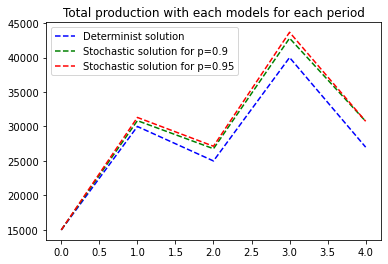

In [47]:
TotalProd90 = [15000.0,30845.938188974418, 26773.01167303558, 42800.50393639502, 30754.008856745008]
TotalProd95 = [15000.0, 31309.987461682693, 27133.733833857055, 43664.57589972583, 30754.008856745008]

#plt.plot(np.transpose(Scen));
plt.plot([0,1,2,3,4],TotalProd,'--',color = 'blue', label = 'Determinist solution')
plt.plot([0,1,2,3,4],TotalProd90,'--',color = 'green', label = 'Stochastic solution for p=0.9')
plt.plot([0,1,2,3,4],TotalProd95,'--',color = 'red', label = 'Stochastic solution for p=0.95')
plt.title("Total production with each models for each period")
plt.legend()

In the stochastic models, the thermal reactor are still used in majority. In fact there are even more used than with determinist solution. Which is interesting to see is that for a more scenario covered ($p=0.95$) the use of thermal generator is less than with $p=0.9$.

This is counter by an increase of the use of hydroplants B ( the more powerful one) starting in period 1. However, the pumping is not done while the hydro plants are on for $p=0.9$, but there are with $p=0.95$ with a more important pumping when the demand is at a minimum point ( period 0 and 2).

---
## Task 5

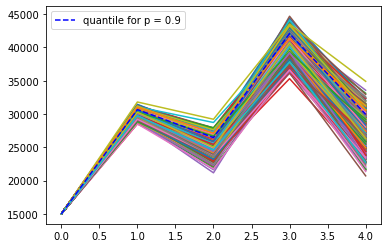

 228 scenarios remain over the 1000 initial ones


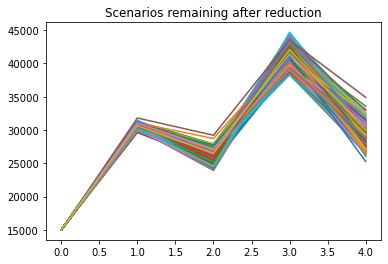

In [18]:
# Task 5

#Pre-processed
#generate the random scenario
Nscen = 1000
p = 0.9
np.random.seed(0)
Scen = np.random.multivariate_normal(demand[1:], Cov, Nscen)
#add the first known demand
premier = demand[0]*np.ones((Nscen,1))
Scen = np.concatenate((premier,Scen), axis = 1)
plt.plot(np.transpose(Scen));

#calcul of the quantile
pquantile = np.zeros(nperiods)
for period in range(nperiods):
    pquantile[period] = np.quantile(Scen[:,period],p)
plt.plot([0,1,2,3,4],pquantile,'--',color = 'blue', label = f"quantile for p = {p}")
plt.legend()
plt.show()

#reduction of the samples
i = 0
Scenbis = np.copy(Scen)
for iscen in range(Nscen):
    j = 0
    for period in range(nperiods):
        if Scen[iscen,period] <= pquantile[period]:
            j+=1
        if j==nperiods:
            Scenbis = np.delete(Scenbis,iscen-i, 0)
            i+=1
#Add the fictive scienario with a weight equals to the sum of the probabilities under it 
Scenbis = np.append(Scenbis,[pquantile], axis=0)
Pr = [1/Nscen for n in range(Nscen-i)] + [sum([1/Nscen for j in range(i)])]
#Plot the result
plt.plot(np.transpose(Scenbis));
plt.title("Scenarios remaining after reduction")
print(f" {Nscen-i} scenarios remain over the {Nscen} initial ones") 

In [17]:
# Apply the model to the reduced samples
#Ajouter z binaire
#z = model.addVars(Nscen, vtype=GRB.BINARY, name="prob")
#Meet demand
meet_demand = model.addConstrs(gp.quicksum(output[type, period] for type in range(ntypes)) +
                               gp.quicksum(hydro_load[unit]*hydro[unit,period] for unit in range(hydrounits))
                               >= z[iscen]*Scenbis[iscen,period] + pumping[period]
                               for period in range(nperiods) 
                               for iscen in range(Nscen-i+1))
#Probability
probability = model.addConstr((gp.quicksum(z[iscen]*Pr[iscen] for iscen in range(Nscen-i+1))) >= p )
model.update()
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1226 rows, 1075 columns and 8444 nonzeros
Model fingerprint: 0xc285ea59
Variable types: 25 continuous, 1050 integer (1020 binary)
Coefficient statistics:
  Matrix range     [1e-03, 4e+04]
  Objective range  [4e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 4e+04]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 23 rows and 775 columns
Presolve time: 0.01s
Presolved: 1203 rows, 300 columns, 8387 nonzeros
Variable types: 25 continuous, 275 integer (246 binary)
Found heuristic solution: objective 1230451.9932
Found heuristic solution: objective 1207955.2644
Found heuristic solution: objective 1189893.3784

Root relaxation: objective 1.065159e+06, 298 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl

---

The optimized solution for $p = 0.9$ is $1,087,366.818975$€ with $Nscen = 1000$ reduced to $229$ compared to solution found for $Nscen=300$: $1,084,822.899110€$. This gives a ratio of $1.002345$ showing that the results obtained with less scenario is consistent.

The optimized solution for $p = 0.95$ with $Nscen = 1000$ reduced to $125$ is out of ranged for the size-limited version. But as just said before, it seems that $300$ scenarios are enough for this modelization. However, one has to keep in mind that the result could be different with a different probability level and it is not enough to conclude that the results obtained with $Nscen=300$ is acceptable.

---
## References

H. Paul Williams, Model Building in Mathematical Programming, fifth edition.

W. de Oliveira, Cours Mines28 semaine PSL. Slides at www.oliveira.mat.br/teaching 
